#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 18
**CH18 Forecasting daily ticket sales for a swimming pool**

using using swim data

version 1.0 2021-05-05

In [ ]:
# Import the pandas_market_calendars module
%pip install pandas_market_calendars
import pandas_market_calendars as mcal

import os
import sys
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
from mizani.formatters import date_format
from patsy import dmatrices
from plotnine import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/swim-transactions/clean/"
data_out = dirname + "da_case_studies/ch18-swim-transactions/"
output = dirname + "da_case_studies/ch18-swim-transactions/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


### Read data

In [3]:
daily_agg = pd.read_csv("/workspaces/codespaces-jupyter/data/swim_work.csv", parse_dates=["date"])
#daily_agg = pd.read_csv("https://osf.io/download/jcxmk/", parse_dates=["date"])


In [4]:
daily_agg.head()

,date,QUANTITY
0,2010-01-01,0
1,2010-01-02,49
2,2010-01-03,31
3,2010-01-04,14
4,2010-01-05,18


In [5]:
daily_agg["year"] = daily_agg["date"].dt.year
daily_agg["quarter"] = daily_agg["date"].dt.quarter
daily_agg["month"] = daily_agg["date"].dt.month
daily_agg["day"] = daily_agg["date"].dt.day
daily_agg["dow"] = daily_agg["date"].dt.dayofweek + 1
daily_agg["weekend"] = daily_agg["dow"].isin([6, 7])


In [8]:
daily_agg

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend
0,2010-01-01,0,2010,1,1,1,5,False,False,1
1,2010-01-02,49,2010,1,1,2,6,True,False,2
2,2010-01-03,31,2010,1,1,3,7,True,False,3
3,2010-01-04,14,2010,1,1,4,1,False,False,4
4,2010-01-05,18,2010,1,1,5,2,False,False,5
...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556


In [6]:
daily_agg["school_off"] = (
    ((daily_agg["day"] > 15) & (daily_agg["month"] == 5) & (daily_agg["day"] <= 30))
    | ((daily_agg["month"] == 6) | (daily_agg["month"] == 7))
    | ((daily_agg["day"] < 15) & (daily_agg["month"] == 8))
    | ((daily_agg["day"] > 20) & (daily_agg["month"] == 12))
)

In [7]:
daily_agg["trend"] = daily_agg.index + 1

In [10]:
# Get holiday calendar ----------------------------------


In [ ]:
nyse = mcal.get_calendar("NYSE")

   ━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━ 3/5 [exchange-calendars]  WARNING: The script ecal is installed in '/usr/local/python/3.12.1/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [pandas_market_calendars]_market_calendars]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
holidays = nyse.holidays().holidays

daily_agg["isHoliday"] = daily_agg["date"].isin(holidays)


In [15]:
most_recent_holiday = max(holiday for holiday in holidays if holiday <= np.datetime64('today'))
most_recent_holiday

np.datetime64('2025-07-04')

In [16]:
daily_agg.describe()

,date,QUANTITY,year,quarter,month,day,dow,trend
count,2557,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000
mean,2013-07-02 00:00:00,47.867032,2013.000782,2.508408,6.522487,15.730935,4.001173,1279.000000
min,2010-01-01 00:00:00,0.000000,2010.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2011-10-02 00:00:00,14.000000,2011.000000,2.000000,4.000000,8.000000,2.000000,640.000000
50%,2013-07-02 00:00:00,28.000000,2013.000000,3.000000,7.000000,16.000000,4.000000,1279.000000
75%,2015-04-02 00:00:00,64.000000,2015.000000,4.000000,10.000000,23.000000,6.000000,1918.000000
max,2016-12-31 00:00:00,287.000000,2016.000000,4.000000,12.000000,31.000000,7.000000,2557.000000
std,NaN,50.491050,2.000587,1.117346,3.449499,8.802361,2.000097,738.286643


### Define vars for analysis

In [17]:
daily_agg["q_month"] = daily_agg.groupby("month")["QUANTITY"].transform("mean")

daily_agg["QUANTITY2"] = np.where(daily_agg["QUANTITY"] < 1, 1, daily_agg["QUANTITY"])

daily_agg["q_ln"] = np.log(daily_agg["QUANTITY2"])

daily_agg["tickets"] = daily_agg.groupby(["month", "dow"])["QUANTITY"].transform("mean")

daily_agg["tickets_ln"] = daily_agg.groupby(["month", "dow"])["q_ln"].transform("mean")

daily_agg["dow_abb"] = daily_agg["date"].dt.day_name().str[:3]

daily_agg["month_abb"] = daily_agg["date"].dt.month_name().str[:3]


In [27]:
daily_agg

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday,q_month,QUANTITY2,q_ln,tickets,tickets_ln,dow_abb,month_abb
0,2010-01-01,0,2010,1,1,1,5,False,False,1,True,21.271889,1,0.000000,5.156250,1.389561,Fri,Jan
1,2010-01-02,49,2010,1,1,2,6,True,False,2,False,21.271889,49,3.891820,36.312500,3.443075,Sat,Jan
2,2010-01-03,31,2010,1,1,3,7,True,False,3,False,21.271889,31,3.433987,39.343750,3.519238,Sun,Jan
3,2010-01-04,14,2010,1,1,4,1,False,False,4,False,21.271889,14,2.639057,16.900000,2.726322,Mon,Jan
4,2010-01-05,18,2010,1,1,5,2,False,False,5,False,21.271889,18,2.890372,16.800000,2.675239,Tue,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553,False,15.972350,12,2.484907,14.612903,2.507322,Tue,Dec
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554,False,15.972350,17,2.833213,14.903226,2.470384,Wed,Dec
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555,False,15.972350,27,3.295837,13.093750,2.321463,Thu,Dec
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556,False,15.972350,3,1.098612,7.096774,1.629852,Fri,Dec


In [28]:
daily_agg["year"].value_counts()

year
2012    366
2016    366
2010    365
2011    365
2013    365
2014    365
2015    365
Name: count, dtype: int64

## Descriptive graphs

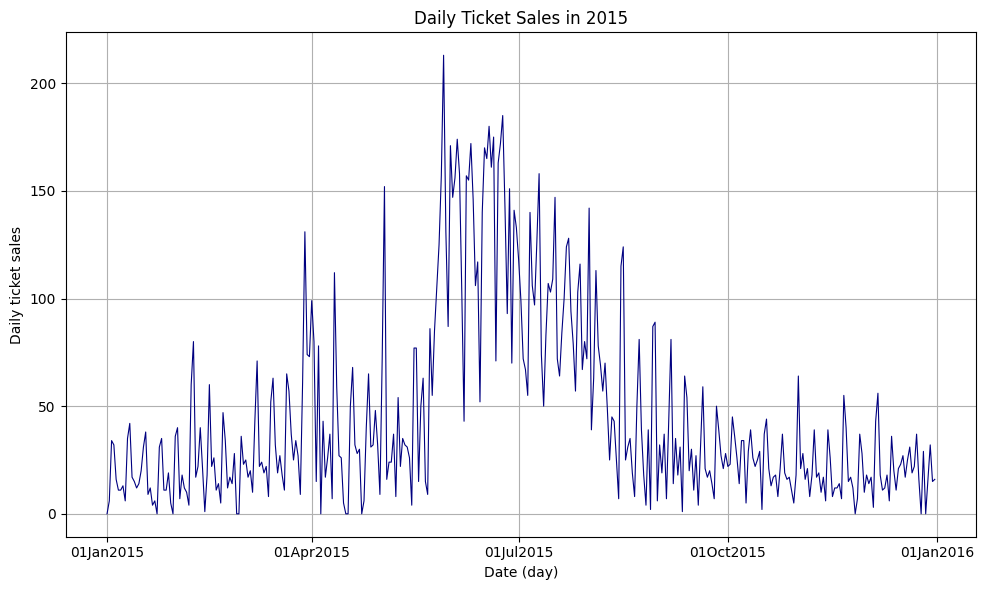

In [24]:
# Filter data for the year 2015
data_2015 = daily_agg[daily_agg['year'] == 2015]


plt.figure(figsize=(10, 6))
sns.lineplot(data=data_2015, x='date', y='QUANTITY', color='navy', linewidth=0.8)


plt.xticks(
    ['2015-01-01', '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-01'],
    ['01Jan2015', '01Apr2015', '01Jul2015', '01Oct2015', '01Jan2016'],
    rotation=0
)


plt.xlabel('Date (day)')
plt.ylabel('Daily ticket sales')
plt.title('Daily Ticket Sales in 2015')


plt.grid(True)
plt.tight_layout()
plt.show()


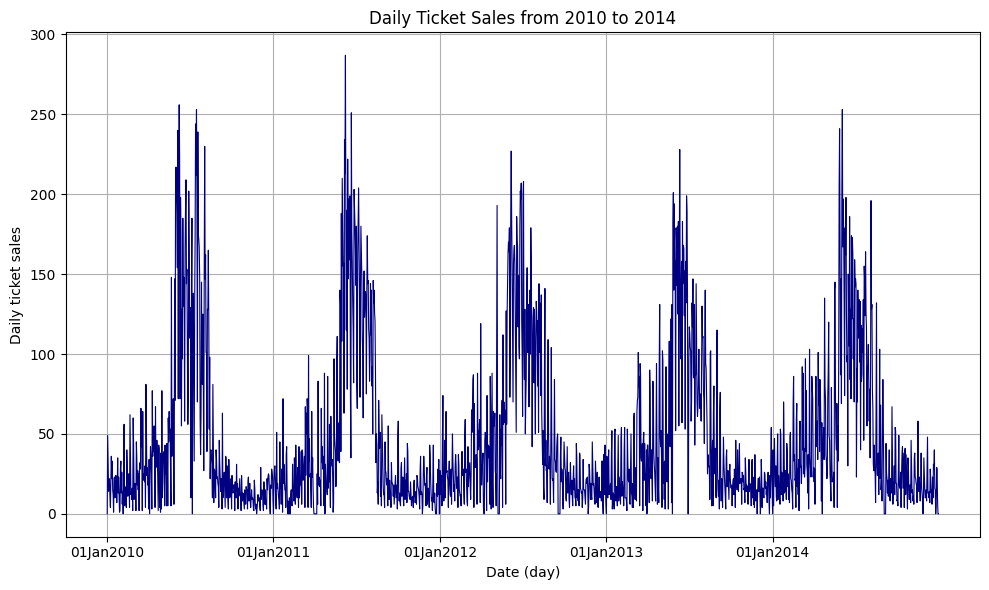

In [23]:
# Filter data for the years 2010 to 2013
data_2010_2013 = daily_agg[(daily_agg['year'] >= 2010) & (daily_agg['year'] <= 2014)]


plt.figure(figsize=(10, 6))
sns.lineplot(data=data_2010_2013, x='date', y='QUANTITY', color='navy', linewidth=0.8)


plt.xticks(
    ['2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01'],
    ['01Jan2010', '01Jan2011', '01Jan2012', '01Jan2013', '01Jan2014'],
    rotation=0
)

plt.xlabel('Date (day)')
plt.ylabel('Daily ticket sales')
plt.title('Daily Ticket Sales from 2010 to 2014')


plt.grid(True)
plt.tight_layout()
plt.show()


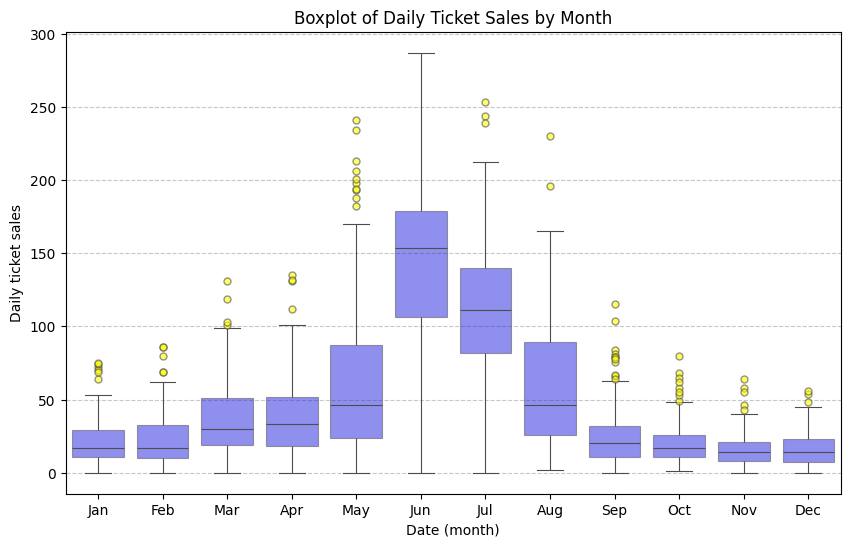

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=daily_agg,
    x="month_abb",
    y="QUANTITY",
    color="blue",
    flierprops={
        "marker": "o",
        "markerfacecolor": "yellow",
        "alpha": 0.6,
        "markersize": 5,
        "linestyle": "none",
    },
    linewidth=0.8,
    boxprops={"alpha": 0.5},  # Set transparency for the boxes
)
plt.xlabel("Date (month)")
plt.ylabel("Daily ticket sales")
plt.title("Boxplot of Daily Ticket Sales by Month")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


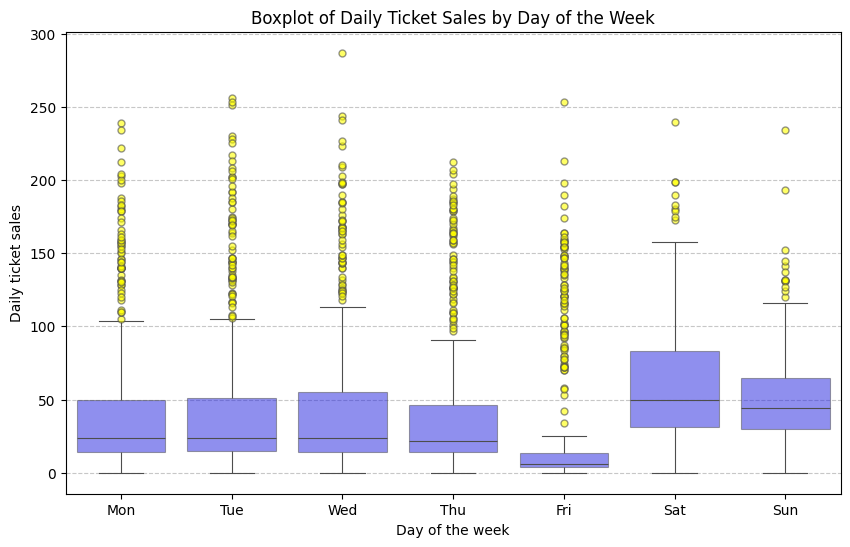

In [ ]:
days_order = daily_agg["dow_abb"].astype("category").cat.reorder_categories(
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], ordered=True
)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=daily_agg,
    x=days_order,
    y="QUANTITY",
    color="blue",
    flierprops={
        "marker": "o",
        "markerfacecolor": "yellow",
        "alpha": 0.6,
        "markersize": 5,
        "linestyle": "none",
    },
    linewidth=0.8,
    boxprops={"alpha": 0.5},  # Set transparency for the boxes
)
plt.xlabel("Day of the week")
plt.ylabel("Daily ticket sales")
plt.title("Boxplot of Daily Ticket Sales by Day of the Week")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


/tmp/ipykernel_1803/3476083349.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


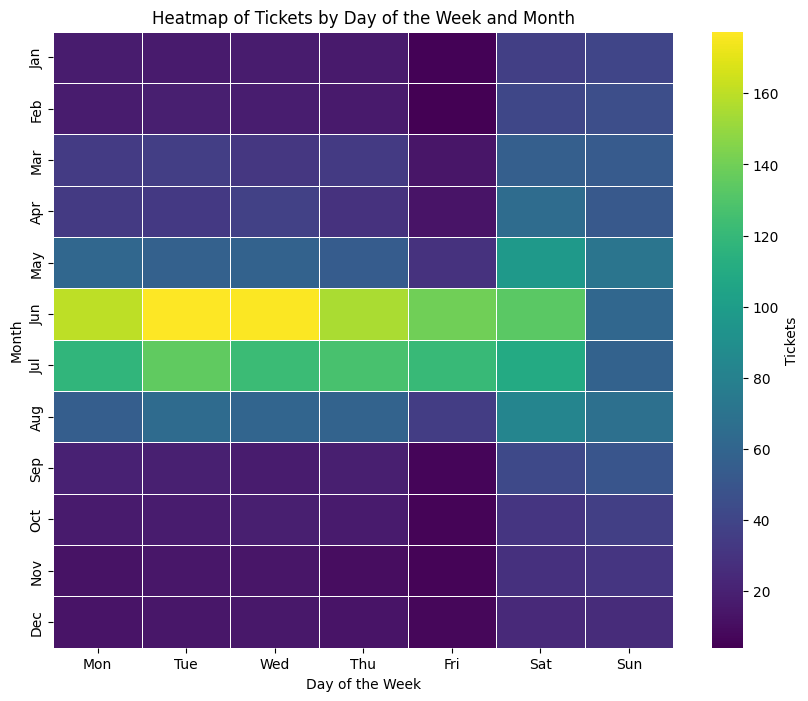

In [49]:
months_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
daily_agg["months_order"] = daily_agg["month_abb"].astype("category").cat.reorder_categories(
    months_order, ordered=True
)

plt.figure(figsize=(10, 8))
# Add the days_order variable as a column in the DataFrame
daily_agg["days_order"] = days_order

heatmap_data = daily_agg.pivot_table(
    index="months_order", columns="days_order", values="tickets", aggfunc="mean"
)

sns.heatmap(
    heatmap_data,
    cmap="viridis",  # Change the palette here
    annot=False,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Tickets"},
)

plt.xlabel("Day of the Week")
plt.ylabel("Month")
plt.title("Heatmap of Tickets by Day of the Week and Month")
plt.show()


/tmp/ipykernel_1803/1036253997.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


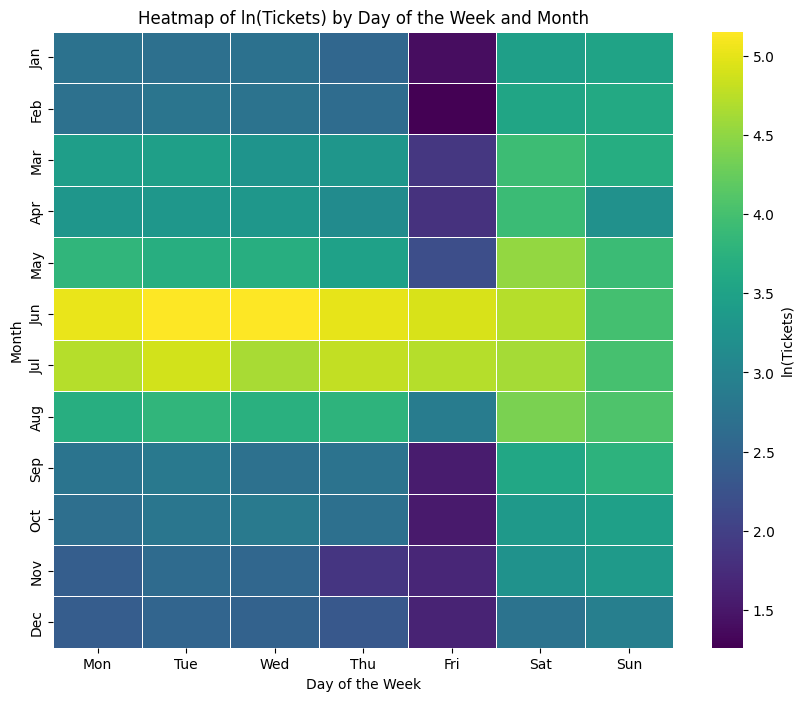

In [50]:
months_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
daily_agg["months_order"] = daily_agg["month_abb"].astype("category").cat.reorder_categories(
    months_order, ordered=True
)

plt.figure(figsize=(10, 8))
# Add the days_order variable as a column in the DataFrame
daily_agg["days_order"] = days_order

heatmap_data = daily_agg.pivot_table(
    index="months_order", columns="days_order", values="tickets_ln", aggfunc="mean"
)

sns.heatmap(
    heatmap_data,
    cmap="viridis",  # Change the palette here
    annot=False,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "ln(Tickets)"},
)

plt.xlabel("Day of the Week")
plt.ylabel("Month")
plt.title("Heatmap of ln(Tickets) by Day of the Week and Month")
plt.show()


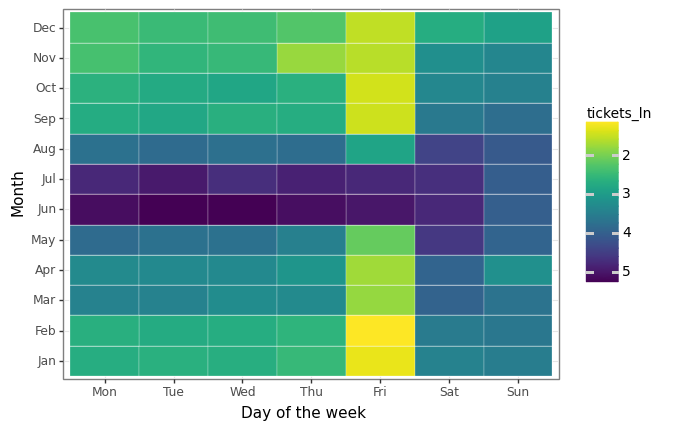

<ggplot: (148645068843)>

In [20]:
# not in book

swim_heatmap_log = (
    ggplot(
        daily_agg,
        aes(x="reorder(dow_abb,dow)", y="reorder(month_abb,month)", fill="tickets_ln"),
    )
    + geom_tile(colour="white")
    + scale_fill_cmap(trans="reverse")
    + labs(x="Day of the week", y="Month")
    + theme_bw()
    + theme(
        legend_position="right",
        legend_text=element_text(size=10),
        legend_title=element_text(size=10),
    )
)
swim_heatmap_log


## Prediction

### Creat train/holdout data

In [21]:
factor_cols = ["month", "dow", "isHoliday", "school_off"]
daily_agg[factor_cols] = daily_agg[factor_cols].astype("category")

data_holdout = daily_agg.loc[daily_agg["year"] == 2016, :]

data_train = daily_agg.loc[daily_agg["year"] < 2016, :]


In [22]:
data_train.tail()


,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday,q_month,QUANTITY2,q_ln,tickets,tickets_ln,dow_abb,month_abb
2186,2015-12-27,0,2015,4,12,27,7,True,True,2187,False,15.97235,1,0.000000,25.266667,2.927724,Sun,Dec
2187,2015-12-28,16,2015,4,12,28,1,False,True,2188,False,15.97235,16,2.772589,13.483871,2.392609,Mon,Dec
2188,2015-12-29,32,2015,4,12,29,2,False,True,2189,False,15.97235,32,3.465736,14.612903,2.507322,Tue,Dec
2189,2015-12-30,15,2015,4,12,30,3,False,True,2190,False,15.97235,15,2.708050,14.903226,2.470384,Wed,Dec
2190,2015-12-31,16,2015,4,12,31,4,False,True,2191,False,15.97235,16,2.772589,13.093750,2.321463,Thu,Dec


In [23]:
logo = LeaveOneGroupOut()
groups = data_train.loc[:, "year"].to_numpy()


In [24]:
data_train.loc[:, "year"].unique()


array([2010, 2011, 2012, 2013, 2014, 2015], dtype=int64)

In [25]:
lin_reg = LinearRegression(fit_intercept=False)


In [26]:
def fit_cv_model_get_rmse(y, X, groups):
    rmse_folds = []
    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lin_reg.fit(X_train, y_train)
        y_hat = lin_reg.predict(X_test)
        rmse_folds.append(mean_squared_error(y_test, y_hat, squared=False))

    return np.mean(rmse_folds)


In [27]:
# Model 1 linear trend + monthly seasonality

y, X = dmatrices("QUANTITY ~ 1+ trend + month", data_train)

rmse_reg1 = fit_cv_model_get_rmse(y, X, groups)


In [28]:
# Model 2 linear trend + monthly seasonality + days of week seasonality

y, X = dmatrices("QUANTITY ~ 1+ trend + month + dow", data_train)

rmse_reg2 = fit_cv_model_get_rmse(y, X, groups)


In [29]:
# Model 3 linear trend + monthly seasonality + days of week  seasonality + holidays

y, X = dmatrices("QUANTITY ~ 1 + trend + month + dow + isHoliday", data_train)

rmse_reg3 = fit_cv_model_get_rmse(y, X, groups)


In [30]:
# Model 4 linear trend + monthly seasonality + days of week  seasonality + holidays + sch*dow

y, X = dmatrices(
    "QUANTITY ~ 1 + trend + month + dow + isHoliday + school_off*dow", data_train
)

rmse_reg4 = fit_cv_model_get_rmse(y, X, groups)


In [31]:
# Model 5 linear trend + monthly seasonality + days of week  seasonality + holidays + interactions

y, X = dmatrices(
    "QUANTITY ~ 1 + trend + month + dow + isHoliday + school_off*dow+ weekend*month",
    data_train,
)

rmse_reg5 = fit_cv_model_get_rmse(y, X, groups)


In [32]:
data_train2 = data_train.loc[lambda x: x.QUANTITY >= 1]
groups = data_train2.loc[:, "year"].to_numpy()


In [33]:
y, X = dmatrices("q_ln ~ 1 + trend + month + dow +school_off*dow", data_train2)

rmse_folds = []
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lin_reg.fit(X_train, y_train)

    y_hat = lin_reg.predict(X)

    corrb = mean_squared_error(y, y_hat)

    y_hat = np.exp((lin_reg.predict(X_test) + corrb / 2))

    rmse_folds.append(mean_squared_error(np.exp(y_test), y_hat, squared=False))


# NOTE: this is different from book -- TODO: check why

rmse_reg6 = np.mean(rmse_folds)
rmse_reg6


30.04481312490464

In [34]:
# Use prophet prediction -------------------------------------------
# add CV into prophet
# can be done with prophet: https://facebook.github.io/prophet/docs/diagnostics.html
# done but this is a different cross-validation as for the other models as it must be time-series like

# prophet -  multiplicative option -- tried but produced much worse results (~34. RMSE)

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


Importing plotly failed. Interactive plots will not work.


In [35]:
model_prophet = Prophet(
    seasonality_mode="additive",
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    growth="linear",
    daily_seasonality=True,
)

model_prophet = Prophet.add_country_holidays(model_prophet, "US")


In [36]:
model_prophet = Prophet.fit(
    model_prophet,
    df=data_train[["date", "QUANTITY"]].rename({"date": "ds", "QUANTITY": "y"}, axis=1),
)


17:45:41 - cmdstanpy - INFO - Chain [1] start processing
17:45:42 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
cv_pred = cross_validation(
    model_prophet, initial="365 days", period="365 days", horizon="365 days"
)


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/5 [00:00<?, ?it/s]

17:45:42 - cmdstanpy - INFO - Chain [1] start processing
17:45:42 - cmdstanpy - INFO - Chain [1] done processing
17:45:42 - cmdstanpy - INFO - Chain [1] start processing
17:45:42 - cmdstanpy - INFO - Chain [1] done processing
17:45:43 - cmdstanpy - INFO - Chain [1] start processing
17:45:43 - cmdstanpy - INFO - Chain [1] done processing
17:45:43 - cmdstanpy - INFO - Chain [1] start processing
17:45:43 - cmdstanpy - INFO - Chain [1] done processing
17:45:44 - cmdstanpy - INFO - Chain [1] start processing
17:45:44 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
rmse_prophet_cv = performance_metrics(cv_pred, rolling_window=1)["rmse"].values[0]


In [39]:
# Note: M6 log model rmse is slightly different from book
pd.DataFrame(
    [rmse_reg1, rmse_reg2, rmse_reg3, rmse_reg4, rmse_reg5, rmse_reg6, rmse_prophet_cv],
    ["M" + str(i) for i in range(1, 6)] + ["M6 (log)", "M7 (Prophet)"],
    columns=["RMSE"],
).round(2)


,RMSE
M1,32.35
M2,31.45
M3,31.46
M4,27.60
M5,26.90
M6 (log),30.04
M7 (Prophet),29.46


## Evaluate best model on holdout set

In [40]:
lin_reg = LinearRegression(fit_intercept=False)

y, X = dmatrices(
    "QUANTITY ~ 1 + trend + month + dow + isHoliday + school_off*dow+ weekend*month",
    data_train,
)

lin_reg.fit(X, y)

_, X_holdout = dmatrices(
    "QUANTITY ~ 1 + trend + month + dow + isHoliday + school_off*dow+ weekend*month",
    data_holdout,
)
data_holdout["y_hat_5"] = lin_reg.predict(X_holdout)


In [41]:
rmse_holdout_best = mean_squared_error(
    data_holdout.QUANTITY, data_holdout.y_hat_5, squared=False
)
rmse_holdout_best


24.577496175560597

### Plot best predictions

In [42]:
# graph relative RMSE (on holdout) per month

group = data_holdout.sort_values(by=["date"]).groupby("month")
rmse_monthly = pd.DataFrame(
    {
        "date": group["date"].first(),
        "RMSE": group.apply(
            lambda x: mean_squared_error(x["QUANTITY"], x["y_hat_5"], squared=False)
        ),
        "RMSE_norm": group.apply(
            lambda x: mean_squared_error(x["QUANTITY"], x["y_hat_5"], squared=False)
            / np.mean(x["QUANTITY"])
        ),
    }
).reset_index(drop=True)


### Figure 18.7 b)

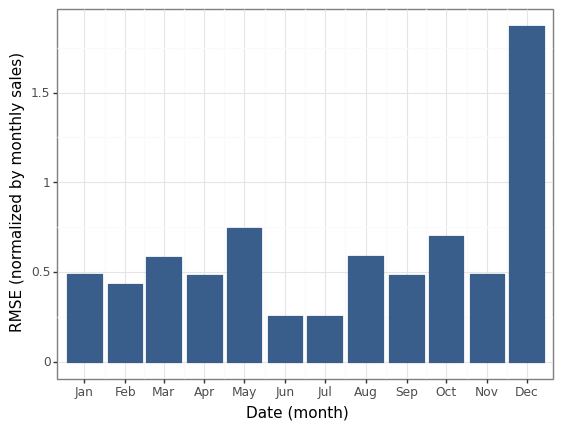

<ggplot: (148641706849)>

In [43]:
(
    ggplot(rmse_monthly, aes(x="date", y="RMSE_norm"))
    + geom_col(color=color[0], fill=color[0])
    + scale_x_date(expand=(0.02, 0.02), labels=date_format("%b"), breaks="1 month")
    + labs(x="Date (month)", y="RMSE (normalized by monthly sales)")
    + theme_bw()
)


In [44]:
plotdata = (
    data_holdout.filter(["date", "month", "QUANTITY", "y_hat_5"])
    .melt(id_vars=["date", "month"])
    .merge(data_holdout.filter(["date", "QUANTITY"]), on="date")
    .merge(data_holdout.filter(["date", "y_hat_5"]), on="date")
    .rename(columns={"QUANTITY": "ymin", "y_hat_5": "ymax"})
)


### Figure 18.6

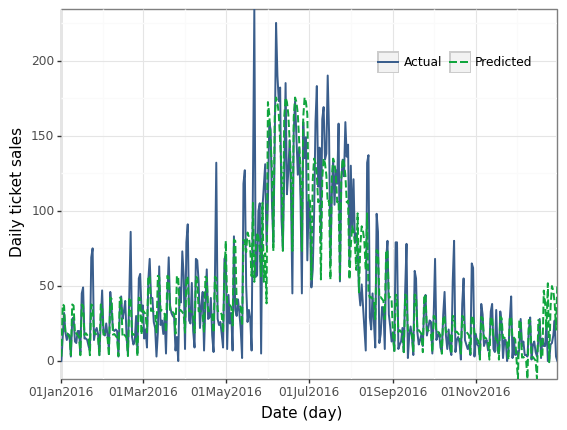

<ggplot: (148648088802)>

In [45]:
(
    ggplot(plotdata, aes(x="date", y="value", color="variable", linetype="variable"))
    + geom_line(size=0.8)
    + scale_y_continuous(expand=(0, 0))
    + scale_x_date(
        expand=(0, 0),
        breaks=[
            "2016-01-01",
            "2016-03-01",
            "2016-05-01",
            "2016-07-01",
            "2016-09-01",
            "2016-11-01",
            "2017-01-01",
        ],
        labels=date_format("%d%b%Y"),
        date_minor_breaks="1 month",
    )
    + scale_linetype_manual(name="", values=("-", "--"))
    + labs(x="Date (day)", y="Daily ticket sales")
    + scale_color_manual(values=(color[0], color[1]), labels=("Actual", "Predicted"))
    + scale_linetype_manual(values=("-", "--"), labels=("Actual", "Predicted"))
    + theme_bw()
    + theme(
        legend_position=(0.74, 0.77),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_background=element_blank(),
        legend_box_background=element_rect(color="white"),
    )
)

### Figure 18.7 a)

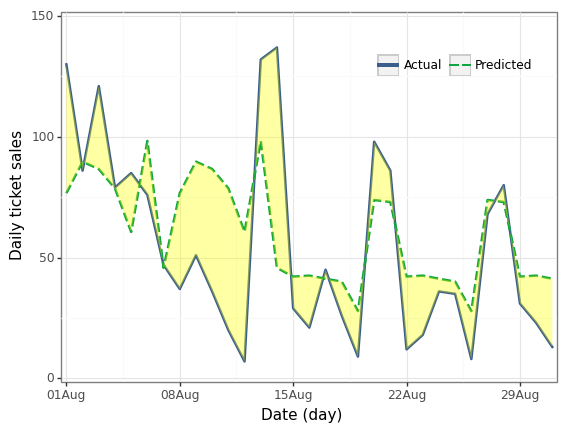

<ggplot: (148648035054)>

In [46]:
(
    ggplot(
        plotdata.loc[lambda x: x["month"] == 8].reset_index(),
        aes(x="date", y="value", color="variable", linetype="variable"),
    )
    + geom_line(size=1)
    + geom_ribbon(
        aes(ymin="ymin", ymax="ymax"),
        fill="yellow",
        color=None,
        alpha=0.2,
        show_legend=False,
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 150))
    + scale_x_date(
        expand=(0.01, 0.01),
        breaks=["2016-08-01", "2016-08-08", "2016-08-15", "2016-08-22", "2016-08-29"],
        labels=date_format("%d%b"),
    )
    + scale_color_manual(values=(color[0], color[1]), labels=("Actual", "Predicted"))
    + scale_linetype_manual(values=("-", "--"), labels=("Actual", "Predicted"))
    + labs(x="Date (day)", y="Daily ticket sales")
    + theme_bw()
    + theme(
        legend_position=(0.74, 0.77),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_background=element_blank(),
        legend_box_background=element_rect(color="white"),
    )
)